In [1]:
get_ipython().magic(u'matplotlib inline')
import sys, os, re, json, urllib, requests
from bs4 import BeautifulSoup
import operator
import pandas as pd
import numpy as np
import time
import logging
from collections import Counter
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
import time
from datetime import date, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score


In [2]:
# EMDAT Flood data 2004-2018 and WorldBank
disaster_wb = pd.read_csv('all_wb.csv',encoding="ISO-8859-1")
disaster_wb = disaster_wb.rename(columns={'Magnitude value':'Magnitude', 'Disaster type':'DisasterType', 'Disaster subtype':'DisasterSubtype',
                                          'Associated disaster':'AssociatedDisaster', 'Associated disaster2':'AssociatedDisaster2', 
                                          'Total deaths':'TotalDeaths', 'Total affected':'TotalAffected', "Total damage ('000 US$)":"TotalDamage",
                                          "Insured losses ('000 US$)":"InsuredLosses", 'NY.ADJ.NNTY.PC.CD':'AdjustedIncome',
                                          "NY.GDP.MKTP.CD":"GDP","SM.POP.REFG.OR":"Refugees","SP.POP.TOTL":"Population"
                                        })
disaster_wb.drop(['Latitude','Longitude','Location','SI.POV.NAPR.ZS','SI.POV.NGAP','VC.BTL.DETH','Disaster No.','Disaster name','iso2c','ISO','Magnitude scale','country','SI.POV.GINI'],axis=1,inplace=True)
disaster_wb['Start.Day'] = disaster_wb['Start.Day'].fillna(1).astype(int)
disaster_wb['Start.Month'] = disaster_wb['Start.Month'].fillna(1).astype(int)
disaster_wb['Start.Year'] = disaster_wb['Start.Year'].astype(int)
disaster_wb['End.Day'] = disaster_wb['End.Day'].fillna(1).astype(int)
disaster_wb['End.Month'] = disaster_wb['End.Month'].fillna(1).astype(int)
disaster_wb['End.Year'] = disaster_wb['End.Year'].astype(int)
disaster_wb['Duration']=disaster_wb.apply(lambda x: (date(x['End.Year'],x['End.Month'],x['End.Day'])-date(x['Start.Year'],x['Start.Month'],x['Start.Day'])).days+1,axis=1)

In [3]:
AssociatedDisaster = list(set(disaster_wb['AssociatedDisaster'].tolist()+disaster_wb['AssociatedDisaster2'].tolist()))
print(AssociatedDisaster)
for row in AssociatedDisaster:
    disaster_wb[row] = disaster_wb.AssociatedDisaster.str.contains(re.escape(row))|disaster_wb.AssociatedDisaster2.str.contains(re.escape(row))

['Surge', 'Industrial accidents', 'Rain', 'Wildfire', 'Snow/ice', 'Crop failure', 'Tsunami/Tidal wave', 'Explosion', 'Avalanche (Snow, Debris)', 'Liquefaction', 'Flood', 'Cold wave', 'Hail', 'Slide (land, mud, snow, rock)', 'Pollution', 'Collapse', '--', 'Transport accident', 'Oil spill', 'Storm', 'Epidemic', 'Lightening', 'Fire', 'Broken Dam/Burst bank']


In [4]:
disaster_wb = pd.get_dummies(disaster_wb, prefix=['DT','DST'], prefix_sep='_', dummy_na=False, columns=['DisasterType','DisasterSubtype']) 

In [5]:
dropped_cols = ['AssociatedDisaster','AssociatedDisaster2','--','Start.Day','Start.Month','End.Day','End.Month','End.Year',
               'DT.ODA.DACD.EMRC.CD','DT.ODA.DACD.EMRC.DISA.CD','DT.ODA.DACD.RFGE.CD','EN.CLC.DRSK.XQ','EN.CLC.MDAT.ZS',
               'MO.INDEX.HDEV.XQ','UNDP.HDI.XD','VC.IDP.TOCV','DST_--','Start.Year','Refugees']
disaster_wb.drop(dropped_cols,axis=1,inplace=True)
final_df = disaster_wb.dropna(subset=['Magnitude'])

In [6]:
# Impute null values using median value from the same country, We dont have data for some countries in some specific years
colnames = ['AdjustedIncome', 'GDP', 'Population']
for col in colnames:
    Val_NULL = final_df[final_df[col].isnull()]
    temp_df = final_df[final_df[col].notnull()]
    Val_NULL = Val_NULL[Val_NULL.Country.isin(temp_df.Country)]
    Val_NULL = Val_NULL.apply(lambda x : temp_df[temp_df.Country==x.Country][col].median(),axis=1)
    final_df.loc[Val_NULL.index,col] = Val_NULL.values
final_df=final_df.dropna()
final_df=final_df[final_df.TotalAffected>0]

C:\Users\Gilang\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
Label = final_df[['TotalAffected','TotalDamage']].copy()
feature = final_df.drop(['TotalDeaths', 'TotalAffected', 'TotalDamage', 'InsuredLosses'],axis=1)
# Get dummy code for countries
feature = pd.get_dummies(feature, prefix=None, prefix_sep='_', dummy_na=False, columns=['Country'])
feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2272 entries, 2 to 5715
Columns: 188 entries, Magnitude to Country_Zimbabwe
dtypes: bool(23), float64(4), int64(1), uint8(160)
memory usage: 512.5 KB


## Model using Data from 148 Country & All Disasters

In [8]:
model = XGBRegressor()
X = feature.values
y = Label['TotalAffected'].values
MAE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
MSE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
R2 = cross_val_score(model, X, y, cv=5, scoring='r2')

print('Mean Absolute Error',(MAE))
print('Mean Squared Error',(MSE))
print('R2',(R2))

Mean Absolute Error [-2129165.76943681 -1318364.28749517  -909949.80043063  -462891.14267492
  -529015.31628848]
Mean Squared Error [-1.04440275e+14 -1.49529044e+13 -7.03327602e+12 -2.20888547e+12
 -5.57117122e+12]
R2 [ 0.08103996 -0.45638455 -1.14489128 -0.14195112 -0.12373908]


C:\Users\Gilang\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


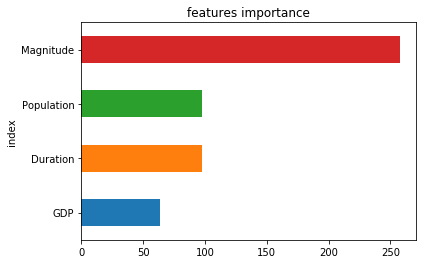

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

X, y = feature.values, Label['TotalAffected'].values
model_xgb = Pipeline([('scaler',StandardScaler()),('method', XGBRegressor(learning_rate=0.1, scale_pos_weight=1))])
model_xgb.fit(X, y)
mapFeat = dict(zip(["f"+str(i) for i in range(len(feature.columns))],feature.columns))
ts = pd.Series(model_xgb.named_steps["method"].get_booster().get_score(importance_type='weight'))
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-4:].plot(figsize=(6, 4), kind="barh", title=("features importance"))

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = feature.values
y = Label['TotalAffected'].values
MAE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
MSE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
R2 = cross_val_score(model, X, y, cv=5, scoring='r2')

print('Mean Absolute Error',(MAE))
print('Mean Squared Error',(MSE))
print('R2',(R2))

Mean Absolute Error [-2343014.68577832 -1887395.07492425 -1756763.58029057 -1319279.12868092
 -1919001.48141421]
Mean Squared Error [-1.11348685e+14 -1.11740112e+13 -8.69136581e+12 -3.97061510e+12
 -8.59056271e+12]
R2 [ 0.02025353 -0.08832751 -1.65054786 -1.0527313  -0.73276869]


## Model using Data from Single Country Only

In [11]:
Indonesia=final_df[final_df.Country=='Indonesia'].index
model = XGBRegressor()
X = feature.loc[Indonesia].values
y = Label.loc[Indonesia,'TotalAffected'].values
MAE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
MSE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
R2 = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Mean Absolute Error',(MAE))
print('Mean Squared Error',(MSE))
print('R2',(R2))

Mean Absolute Error [-108240.975625    -98304.07045898  -55392.97872559 -298650.48404297
 -202574.58870443]
Mean Squared Error [-3.17142701e+10 -1.75626566e+10 -8.57811718e+09 -6.55304535e+11
 -2.69675580e+11]
R2 [-0.81436909 -2.95044753 -1.29571524 -0.67552793 -0.07473555]


## Model using Data from Single Disaster Only

In [12]:
Flood=final_df[final_df.DT_Flood==1].index
model = XGBRegressor()
X = feature.loc[Flood].values
y = Label.loc[Flood,'TotalAffected'].values
MAE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
MSE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
R2 = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Mean Absolute Error',(MAE))
print('Mean Squared Error',(MSE))
print('R2',(R2))

Mean Absolute Error [-1018444.09902131 -3101080.96720123 -1509291.24369709  -486278.30736429
  -941835.91406055]
Mean Squared Error [-4.59566324e+13 -1.66348436e+14 -2.90143842e+13 -3.31874219e+12
 -3.51932872e+12]
R2 [ 3.40784433e-03  2.17016058e-02 -1.50553098e+01 -4.92195148e-01
 -2.67159230e+00]


## Model using Data from Single Disaster and Single Country Only

In [13]:
disaster_wb[disaster_wb.DT_Flood==1].Country.value_counts()

China                                                         197
India                                                         168
Indonesia                                                     119
Philippines (the)                                              98
United States of America (the)                                 88
Afghanistan                                                    67
Viet Nam                                                       67
Brazil                                                         66
Pakistan                                                       62
Thailand                                                       56
Colombia                                                       49
Russian Federation (the)                                       46
Kenya                                                          46
Nigeria                                                        43
Bangladesh                                                     41
Mexico    

In [14]:
CountryFlood=final_df[(final_df.DT_Flood==1)&(final_df.Country=='Indonesia')].index
model = XGBRegressor()
X = feature.loc[CountryFlood].values
y = Label.loc[CountryFlood,'TotalAffected'].values
MAE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
MSE = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
R2 = cross_val_score(model, X, y, cv=5, scoring='r2')
print('Mean Absolute Error',(MAE))
print('Mean Squared Error',(MSE))
print('R2',(R2))

Mean Absolute Error [-80578.21448693 -27004.85686786 -50625.00407527 -52352.85392879
 -34931.12129564]
Mean Squared Error [-2.35961844e+10 -2.21781570e+09 -7.94912648e+09 -7.67310147e+09
 -2.81560511e+09]
R2 [ 0.03800278  0.73126048 -0.13097627 -6.59048969  0.33988188]


BETTER than PREVIOUS experiment. More specific the model, the better is the result 

C:\Users\Gilang\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


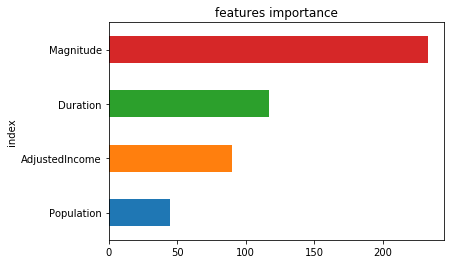

In [19]:
X = feature.loc[CountryFlood].values
y = Label.loc[CountryFlood,'TotalAffected'].values
odel_xgb = Pipeline([('scaler',StandardScaler()),('method', XGBRegressor(learning_rate=0.3, scale_pos_weight=1))])
model_xgb.fit(X, y)
mapFeat = dict(zip(["f"+str(i) for i in range(len(feature.columns))],feature.columns))
ts = pd.Series(model_xgb.named_steps["method"].get_booster().get_score(importance_type='weight'))
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-4:].plot(figsize=(6, 4), kind="barh", title=("features importance"))

C:\Users\Gilang\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


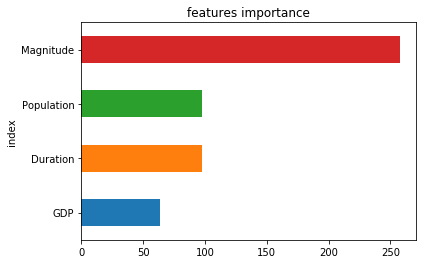

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

X, y = feature.values, Label['TotalAffected'].values
model_xgb = Pipeline([('scaler',StandardScaler()),('method', XGBRegressor(learning_rate=0.1, scale_pos_weight=1))])
model_xgb.fit(X, y)
mapFeat = dict(zip(["f"+str(i) for i in range(len(feature.columns))],feature.columns))
ts = pd.Series(model_xgb.named_steps["method"].get_booster().get_score(importance_type='weight'))
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-4:].plot(figsize=(6, 4), kind="barh", title=("features importance"))

# SANDBOX

C:\Users\Gilang\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


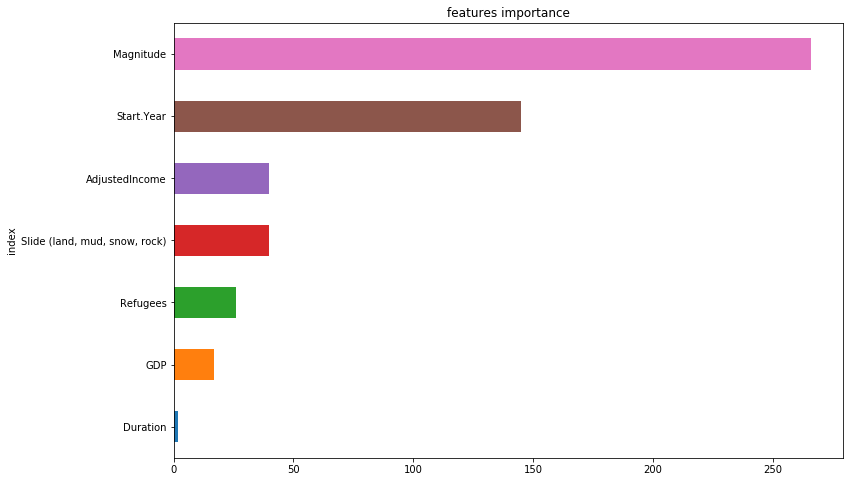

In [57]:

Filter=final_df[(final_df.DT_Earthquake==1)&(final_df.Country=='China')].index
X = feature.loc[Filter].values
y = Label.loc[Filter,'TotalAffected'].values
model_xgb = Pipeline([('scaler',StandardScaler()),('method', XGBRegressor(learning_rate=0.3, scale_pos_weight=1))])
model_xgb.fit(X, y)
mapFeat = dict(zip(["f"+str(i) for i in range(len(feature.columns))],feature.columns))
ts = pd.Series(model_xgb.named_steps["method"].get_booster().get_score(importance_type='weight'))
ts.index = ts.reset_index()['index'].map(mapFeat)
ts.sort_values()[-10:].plot(figsize=(12, 8), kind="barh", title=("features importance"))